Epoch 0, Loss: 0.7659820624015992
Epoch 100, Loss: 0.42992522929344923
Epoch 200, Loss: 0.3211933881183266
Epoch 300, Loss: 0.2413693467145715
Epoch 400, Loss: 0.19078370152979943
Epoch 500, Loss: 0.1619390611918313
Epoch 600, Loss: 0.14536145219813856
Epoch 700, Loss: 0.13483044132634495
Epoch 800, Loss: 0.12746873041817902
Epoch 900, Loss: 0.12198120325951219


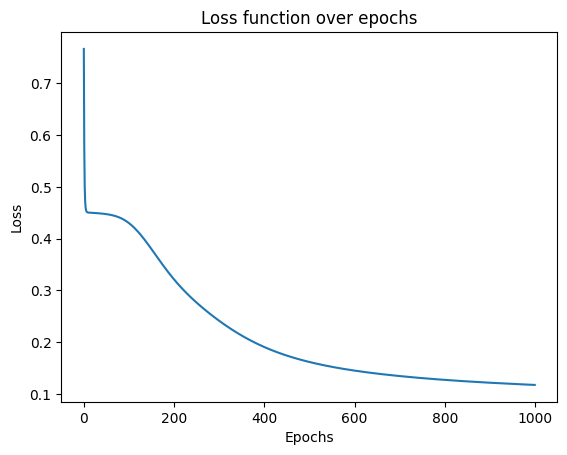

Classification error rate: 12.3%


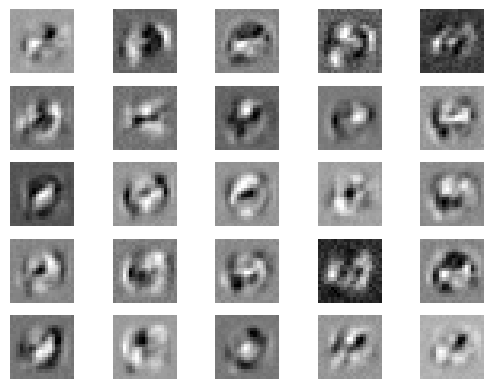

In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

def sigmoid(z):
    # Prevent overflow and underflow for numerical stability
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def sigmoid_gradient(z):
    # Use the more stable version of the sigmoid gradient
    sig = sigmoid(z)
    return sig * (1 - sig)

def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    z2 = a1.dot(theta1.T)
    a2 = np.concatenate([np.ones((m, 1)), sigmoid(z2)], axis=1)
    z3 = a2.dot(theta2.T)
    a3 = sigmoid(z3)
    return a1, z2, a2, z3, a3

def compute_cost(y_enc, a3, m, theta1, theta2, lambda_reg):
    # Compute the mean squared error
    cost = np.sum((a3 - y_enc) ** 2) / (2 * m)
    # Regularization term
    reg_term = (lambda_reg / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:])))
    return cost + reg_term

def backpropagate(a1, a2, a3, theta1, theta2, y_enc, m, lambda_reg):
    delta3 = a3 - y_enc
    delta2 = delta3.dot(theta2)[:, 1:] * sigmoid_gradient(a2[:, 1:])
    Delta1 = delta2.T.dot(a1)
    Delta2 = delta3.T.dot(a2)
    # Add regularization to the gradients
    theta1_grad = (Delta1 + lambda_reg * np.hstack([np.zeros((theta1.shape[0], 1)), theta1[:, 1:]])) / m
    theta2_grad = (Delta2 + lambda_reg * np.hstack([np.zeros((theta2.shape[0], 1)), theta2[:, 1:]])) / m
    return theta1_grad, theta2_grad

def predict(X, theta1, theta2):
    _, _, _, _, a3 = forward_propagate(X, theta1, theta2)
    return np.argmax(a3, axis=1)

def one_hot_encode(y, num_labels):
    y_enc = np.zeros((y.size, num_labels))
    for i in range(y.size):
        y_enc[i, y[i] if y[i] != 10 else 0] = 1
    return y_enc

# Load data
data = scipy.io.loadmat('mnist.mat')
X = data['X']
y = data['y'].flatten()
y[y == 10] = 0  # Replace 10 with 0

# One-hot encode labels
num_labels = 10
y_enc = one_hot_encode(y, num_labels)

# Initialize settings
input_size = 400
hidden_size = 25
learning_rate = 0.0005  # Learning rate
lambda_reg = 0.01  # Regularization parameter to prevent overfitting
epochs = 1000  # Number of epochs for convergence
m = X.shape[0]

# Initialize parameters randomly
np.random.seed(0)
theta1 = np.random.rand(hidden_size, input_size + 1) * 0.12 - 0.06
theta2 = np.random.rand(num_labels, hidden_size + 1) * 0.12 - 0.06

# Training
loss_history = []

for epoch in range(epochs):
    # Implement mini-batch gradient descent
    batch_size = 10  # Size of the batch
    indices = np.arange(m)
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    y_enc_shuffled = y_enc[indices]

    for i in range(0, m, batch_size):
        X_batch = X_shuffled[i:i + batch_size]
        y_batch = y_enc_shuffled[i:i + batch_size]
        a1, z2, a2, z3, a3 = forward_propagate(X_batch, theta1, theta2)
        cost = compute_cost(y_batch, a3, X_batch.shape[0], theta1, theta2, lambda_reg)
        theta1_grad, theta2_grad = backpropagate(a1, a2, a3, theta1, theta2, y_batch, X_batch.shape[0], lambda_reg)
        theta1 -= learning_rate * theta1_grad
        theta2 -= learning_rate * theta2_grad

    # Record and print the cost on the full dataset for monitoring
    _, _, _, _, a3_full = forward_propagate(X, theta1, theta2)
    full_cost = compute_cost(y_enc, a3_full, m, theta1, theta2, lambda_reg)
    loss_history.append(full_cost)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {full_cost}')

# Plot loss function
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss function over epochs')
plt.show()

# Compute classification error rate
predictions = predict(X, theta1, theta2)
error_rate = np.mean(predictions != y) * 100
print(f'Classification error rate: {error_rate}%')

# Visualize learned features
subplot_dim = int(np.ceil(np.sqrt(hidden_size)))
for i in range(hidden_size):
    plt.subplot(subplot_dim, subplot_dim, i+1)
    plt.imshow(theta1[i, 1:].reshape(20, 20), cmap='gray')
    plt.axis('off')
plt.show()